In [1]:
!pip install mwapi

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import mwapi
import numpy as np
import json
pd.set_option("max_colwidth", 500)

The session object is your API connection to a Wikimedia subdomain (or any other wiki using MediaWiki with the API enabled). Change the user agent to your Wikipedia username.

In [3]:
session = mwapi.Session("https://en.wikipedia.org",
                        user_agent="User:Staeiou")

`session.get()` is the main API query function. 

The API is organized hierarchially by action and then property. Most data scraping / read only requests use "action:query" and "prop:XYZ" to specify the properties you want to query. The "prop:revisions" is used to retrieve information by edits to pages (e.g. all edits to the California article). The "prop:contributors" does queries by user (e.g. all edits by Staeiou). See [the_documentation](https://www.mediawiki.org/wiki/API:Properties) for more properties to query.

Each prop module has a set of its own parameters, so prop:revisions has rvprop, where you specify what variables you want returned. There is also a prop-specific limit variable for the number of results per request. The max return size for most queries is 500 items per request. But with the continuation=True parameter in mwapi, it is easier to use a python generator to iterate over to get more than 500 items.

The mwapi library auto-throttles, so don't worry about rate limiting. 

In [4]:
ucsd_revs = session.get(action="query",
                        prop="revisions",
                        titles="University of California, San Diego",
                        rvprop="ids|timestamp|comment|user|userid|size|tags|roles",
                        rvlimit=500,
                        continuation=True)

In [5]:
type(ucsd_revs)

generator

In [6]:
requests = []
for request in ucsd_revs:
    requests.append(request)

In [7]:
len(requests)

8

The raw json from a single request, with 500 revisions. It can be a bit tricky to get just the revisions into a pandas dataframe: 

In [8]:
print(json.dumps(requests[0], indent=2))

{
  "continue": {
    "rvcontinue": "20171117044659|810746942",
    "continue": "||"
  },
  "query": {
    "pages": {
      "31927": {
        "pageid": 31927,
        "ns": 0,
        "title": "University of California, San Diego",
        "revisions": [
          {
            "revid": 1048818404,
            "parentid": 1047751245,
            "user": "Sgweirdo",
            "userid": 39921276,
            "timestamp": "2021-10-08T04:53:33Z",
            "size": 160500,
            "roles": [
              "main"
            ],
            "comment": "",
            "tags": [
              "mobile edit",
              "mobile web edit"
            ]
          },
          {
            "revid": 1047751245,
            "parentid": 1047400554,
            "user": "PrimeBOT",
            "userid": 29463730,
            "timestamp": "2021-10-02T11:26:29Z",
            "size": 160508,
            "roles": [
              "main"
            ],
            "comment": "/* External links */[

We have made 8 requests with a max length of 500 each, so we should have 3500-4000 total revisions. We will iterate through those requests, put them each in a pandas dataframe, then concatenate those 8 dataframes into one.

In [9]:
list_of_dfs = []
for request in requests:
    for page in request['query']['pages'].items():
        list_of_dfs.append(pd.DataFrame(page[1]['revisions']))

In [10]:
revisions_df = pd.concat(list_of_dfs)

In [11]:
revisions_df

,revid,parentid,user,userid,timestamp,size,roles,comment,tags,anon,commenthidden
0,1048818404,1047751245,Sgweirdo,39921276,2021-10-08T04:53:33Z,160500,[main],,"[mobile edit, mobile web edit]",NaN,NaN
1,1047751245,1047400554,PrimeBOT,29463730,2021-10-02T11:26:29Z,160508,[main],/* External links */[[User:PrimeBOT/24|Task 24]]: removal of a template following [[Wikipedia:Templates_for_discussion/Log/2021_September_24|a TFD]],[AWB],NaN,NaN
2,1047400554,1047087304,Citation bot,7903804,2021-09-30T17:23:39Z,160546,[main],Add: date. | [[WP:UCB|Use this bot]]. [[WP:DBUG|Report bugs]]. | Suggested by Anas1712 | [[Category:Public universities and colleges in California]] | #UCB_Category 44/71,[],NaN,NaN
3,1047087304,1044776975,128.54.85.162,0,2021-09-28T23:12:25Z,160526,[main],"Removed Chi Phi as Chapter is no longer active, Removed Sigma Chi as chapter has been suspended from campus and is no longer formally recognized due to Sexual Assault allegations.",[visualeditor],,NaN
4,1044776975,1044746541,MB,26021349,2021-09-17T01:40:15Z,160554,[main],"cleanup, [[WP:AWB/T|typo(s) fixed]]: Center → center, from 2009–2013 → from 2009 to 2013, four year → four-year",[AWB],NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
171,673033,673031,63.207.143.73,0,2003-02-16T09:51:22Z,528,[main],,[],,NaN
172,673031,111585,Zoe,2376,2002-07-06T19:27:04Z,329,[main],*,[],NaN,NaN
173,111585,111583,Zoe,2376,2002-07-06T19:26:18Z,329,[main],*,[],NaN,NaN
174,111583,382242594,Conversion script,1226483,2002-02-25T15:51:15Z,75,[main],Automated conversion,[],NaN,NaN


Convert timestamps to datetime format:

In [12]:
revisions_df['timestamp_dt'] = pd.to_datetime(revisions_df['timestamp'])

revisions_df = revisions_df.set_index("timestamp_dt")

Plotting the size of the article in bytes over time:

Text(0.5, 1.0, 'Size (bytes) of UCSD article over time')

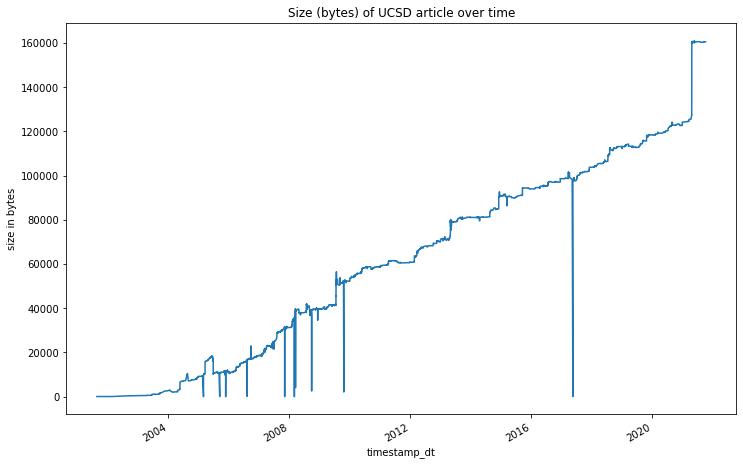

In [13]:
fig = revisions_df['size'].plot(figsize=(12,8))
fig.set_ylabel("size in bytes")
fig.set_title("Size (bytes) of UCSD article over time")

### Regex

In [14]:
import re

AutoWikiBrowser is used for making automated edits. This regex pattern is looking for any version of "[[WP:AWB", "[[Wikipedia:AWB", "[[Wikipedia:AutoWikiBrowser]]", "[[Project:AWB", etc.

In [15]:
pattern = "\[\[(Wikipedia|WP|Project):(AWB|AutoWikiBrowser)"
string = "cleanup, [[WP:AWB/T|typo(s) fixed]]: Center"

In [16]:
result = re.search(pattern, string)
result

<re.Match object; span=(9, 17), match='[[WP:AWB'>

In [17]:
string = "cleanup, [[WP:BBB/T|typo(s) fixed]]: Center"
result = re.search(pattern, string)
type(result)

NoneType

We will create a function for parsing these patterns. The early return statements based on conditionals is mostly for performance, as re.search can be more resource intensive.

In [18]:
def is_awb_regex(comment):
    if comment is None:
        return 0
    if comment is np.nan:
        return 0
    if len(comment) == 0:
        return 0
    
    pattern = "\[\[(Wikipedia|WP|Project):(AWB|AutoWikiBrowser)"
    result = re.search(pattern,comment)
    
    if result is None:
        return 0
    else:
        return 1
    

In [19]:
revisions_df['is_awb_regex'] = revisions_df['comment'].apply(is_awb_regex)

In [20]:
revisions_df[['comment','is_awb_regex']]

,comment,is_awb_regex
timestamp_dt,,
2021-10-08 04:53:33+00:00,,0
2021-10-02 11:26:29+00:00,/* External links */[[User:PrimeBOT/24|Task 24]]: removal of a template following [[Wikipedia:Templates_for_discussion/Log/2021_September_24|a TFD]],0
2021-09-30 17:23:39+00:00,Add: date. | [[WP:UCB|Use this bot]]. [[WP:DBUG|Report bugs]]. | Suggested by Anas1712 | [[Category:Public universities and colleges in California]] | #UCB_Category 44/71,0
2021-09-28 23:12:25+00:00,"Removed Chi Phi as Chapter is no longer active, Removed Sigma Chi as chapter has been suspended from campus and is no longer formally recognized due to Sexual Assault allegations.",0
2021-09-17 01:40:15+00:00,"cleanup, [[WP:AWB/T|typo(s) fixed]]: Center → center, from 2009–2013 → from 2009 to 2013, four year → four-year",1
...,...,...
2003-02-16 09:51:22+00:00,,0
2002-07-06 19:27:04+00:00,*,0
2002-07-06 19:26:18+00:00,*,0


But there is also a tags column that has AWB listed. Here is a function to apply on the tags column:

In [21]:
def is_awb_tags(tags):
    
    if tags is None:
        return 0
    if tags is np.nan:
        return 0
    
    try:
        tag0 = tags[0]
    except Exception:   # If there is no first element
        return 0
    
    if tag0 == "AWB":
        return 1
    else:
        return 0
    

In [22]:
revisions_df['is_awb_tags'] = revisions_df['tags'].apply(is_awb_tags)

If both our regex and the tags field are perfect and accurate, then the correlation should be 1. 

In [23]:
pd.DataFrame(revisions_df[['is_awb_regex','is_awb_tags']].corr())

,is_awb_regex,is_awb_tags
is_awb_regex,1.00000,0.15199
is_awb_tags,0.15199,1.00000


Oh no! What is going on?

In [24]:
pd.DataFrame(revisions_df[['is_awb_regex','is_awb_tags']].value_counts())

,,0
is_awb_regex,is_awb_tags,
0,0,3610
1,0,47
0,1,14
1,1,5


In [25]:
revisions_df[['comment','is_awb_regex','is_awb_tags']].query("is_awb_regex != is_awb_tags")

,comment,is_awb_regex,is_awb_tags
timestamp_dt,,,
2021-10-02 11:26:29+00:00,/* External links */[[User:PrimeBOT/24|Task 24]]: removal of a template following [[Wikipedia:Templates_for_discussion/Log/2021_September_24|a TFD]],0,1
2020-12-27 02:36:34+00:00,[[User:Monkbot/task 18|Task 18 (cosmetic)]]: eval 202 templates: hyphenate params (146×);,0,1
2020-11-29 23:08:13+00:00,[[User:Monkbot/task 18|Task 18 (cosmetic)]]: eval 203 templates: del empty params (27×); hyphenate params (16×); del |ref=harv (6×); del |url-status= (4×);,0,1
2020-08-28 12:36:00+00:00,remove extraneous definite article,0,1
2020-05-30 12:33:57+00:00,"/* History */Journal cites:, added 1 Bibcode",0,1
...,...,...,...
2007-04-18 03:50:40+00:00,"clean up, Replaced: is comprised of → comprises using [[Project:AWB|AWB]]",1,0
2007-02-10 02:10:27+00:00,"Repairing link to disambiguation page - [[Wikipedia:Disambiguation pages with links|You can help!]] , Replaced: [[USC]] → [[University of Southern California|USC]] using [[Project:AWB|AWB]]",1,0
2006-10-24 22:37:40+00:00,"clean up, Replaced: [[USA]] → [[United States|USA]] using [[WP:AWB|AWB]]",1,0


In [26]:
revisions_df[['comment','is_awb_regex','is_awb_tags']].query("is_awb_tags == is_awb_regex")

,comment,is_awb_regex,is_awb_tags
timestamp_dt,,,
2021-10-08 04:53:33+00:00,,0,0
2021-09-30 17:23:39+00:00,Add: date. | [[WP:UCB|Use this bot]]. [[WP:DBUG|Report bugs]]. | Suggested by Anas1712 | [[Category:Public universities and colleges in California]] | #UCB_Category 44/71,0,0
2021-09-28 23:12:25+00:00,"Removed Chi Phi as Chapter is no longer active, Removed Sigma Chi as chapter has been suspended from campus and is no longer formally recognized due to Sexual Assault allegations.",0,0
2021-09-17 01:40:15+00:00,"cleanup, [[WP:AWB/T|typo(s) fixed]]: Center → center, from 2009–2013 → from 2009 to 2013, four year → four-year",1,1
2021-09-16 21:34:39+00:00,"Rmv undefined, unsupported, deprecated infobox parameters",0,0
...,...,...,...
2003-02-16 09:51:22+00:00,,0,0
2002-07-06 19:27:04+00:00,*,0,0
2002-07-06 19:26:18+00:00,*,0,0


### Rolling averages

Proportion of is_awb_regex over various windows. See documentation at: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

<AxesSubplot:xlabel='timestamp_dt'>

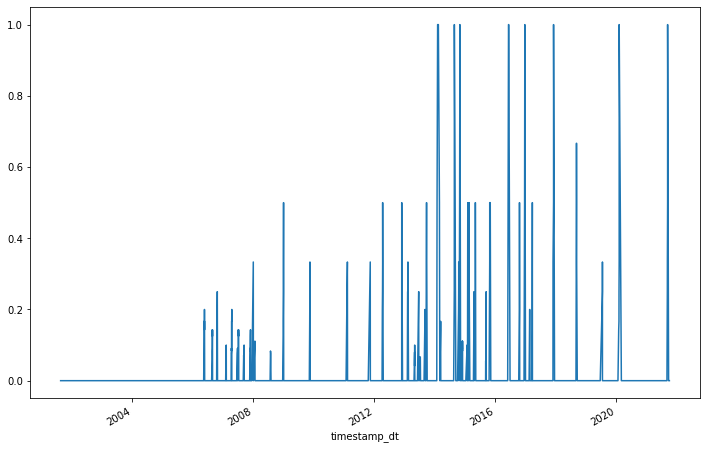

In [27]:
revisions_df['is_awb_regex'].rolling("7D", min_periods=1).mean().plot(figsize=(12,8))

<AxesSubplot:xlabel='timestamp_dt'>

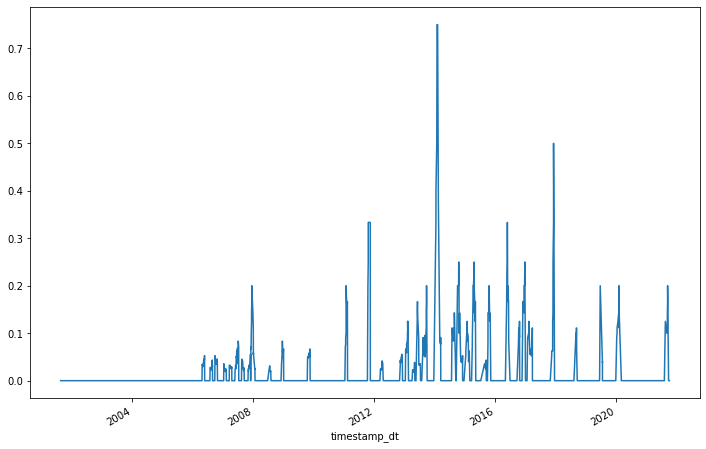

In [28]:
revisions_df['is_awb_regex'].rolling("30D", min_periods=1).mean().plot(figsize=(12,8))

<AxesSubplot:xlabel='timestamp_dt'>

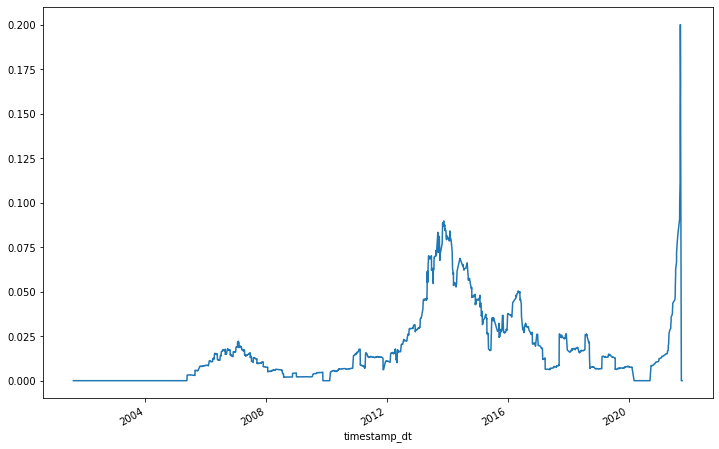

In [29]:
revisions_df['is_awb_regex'].rolling("365D", min_periods=1).mean().plot(figsize=(12,8))

### Assignment part 1

Find an article with at least 20,000 revisions. How has the proportion of users editing from mobile web devices (according to the tags) changed over time? Note that there can be multiple tags in the column.

### Assignment part 2

See the regexes and tags at: https://meta.wikimedia.org/wiki/MediaWiki:XTools-AutoEdits.json
            
Implement functions that can be applied to the revisions_df dataframe to create new columns based on the following tools: 

- global: Huggle, Undo
- en: Generic rollback, undo
- en.wikipedia.org: Huggle, Bot revert, Twinkle

For the article you chose in part 1, how has the proportion of tool-assisted edits changed over time?